In [1]:
import os
import re
import json
import numpy as np
import xarray as xr
import collections
import itertools
import networkx as nx
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Choose chemical mechanism
model_name = 'MCM_C1_C2_ss'
exp_name = 'init'

In [3]:
# Load reaction descriptions
eqs_json_path = os.path.join(os.path.split(os.getcwd())[0], 'MCM', model_name, 'data', model_name, 'eqnjson')
with open(os.path.join(eqs_json_path, model_name+'.json'), 'r') as f:
    all_mcm_eqs = json.load(f)
# Read time series and flux data
ts = xr.open_dataset(os.path.join(os.path.split(os.getcwd())[0], 'processed', model_name+'_'+exp_name+'.nc'))
fl = xr.open_dataset(os.path.join(os.path.split(os.getcwd())[0], 'processed', 'flux', 'flux_'+model_name+'_'+exp_name+'.nc'))

In [4]:
# Convert equation's info to nodes, edges and edge labels needed for networkx
nodes = ['N2'] # nodes
links = [] # edges
link_labels = collections.OrderedDict() # edge labels
flux_labels = collections.OrderedDict()
major_reactants = ['CL', 'H2', 'HO2', 'NO', 'NO2', 'NO3', 'OH', 'SO2', 'SO3'] # 'arrows', no nodes created
for eq in all_mcm_eqs:
    if len(eq['reac']) == 1:
        if 'J' in eq['coef'] and len(eq['prod']) == 1:
            flux_label = eq['reac'][0]+'+hv='+eq['prod'][0]
            link = (eq['reac'][0], eq['prod'][0])
            if flux_label in fl.data_vars:
                links.append(link)
                link_labels[link] = 'hv'
                flux_labels.setdefault(flux_label, []).append(link)
        elif 'J' in eq['coef'] and len(eq['prod']) != 1:
            flux_label = eq['reac'][0]+'+hv='+'+'.join(eq['prod'])
            for prod in eq['prod']:
                link = (eq['reac'][0], prod)
                if flux_label in fl.data_vars:
                    links.append(link)
                    link_labels[link] = 'hv'
                    flux_labels.setdefault(flux_label, []).append(link)
        elif 'J' not in eq['coef'] and len(eq['prod']) == 1:
            flux_label = eq['reac'][0]+'='+eq['prod'][0]
            link = (eq['reac'][0], eq['prod'][0])
            if flux_label in fl.data_vars:
                links.append(link)
                link_labels[link] = ''
                flux_labels.setdefault(flux_label, []).append(link)
        elif 'J' not in eq['coef'] and len(eq['prod']) != 1:
            flux_label = eq['reac'][0]+'='+'+'.join(eq['prod'])
            for prod in eq['prod']:
                link = (eq['reac'][0], prod)
                if flux_label in fl.data_vars:
                    links.append(link)
                    link_labels[link] = ''
                    flux_labels.setdefault(flux_label, []).append(link)
    else: # len(eq['reac']) == 2:
        reac1, reac2 = eq['reac']
        if reac1 in major_reactants and reac2 not in major_reactants:
            reac1, reac2 = reac2, reac1
        if len(eq['prod']) == 1:
            flux_label = '+'.join(eq['reac'])+'='+eq['prod'][0]
            for reac in eq['reac']:
                link = (reac, eq['prod'][0])
                if flux_label in fl.data_vars:
                    links.append(link)
                    link_labels[link] = reac2
                    flux_labels.setdefault(flux_label, []).append(link)
        elif len(eq['prod']) != 1:
            flux_label = '+'.join(eq['reac'])+'='+'+'.join(eq['prod'])
            for reac in eq['reac']:
                for prod in eq['prod']:
                    link = (reac, prod)
                    if flux_label in fl.data_vars:
                        links.append(link)
                        link_labels[link] = reac2
                        flux_labels.setdefault(flux_label, []).append(link)
    for reac in eq['reac']:
        if reac not in nodes:
            nodes.append(reac)
    for prod in eq['prod']:
        if prod not in nodes:
            nodes.append(prod)

In [5]:
# Sample data at a particular hour and model run
hour = 10
ts_hr = {}
fl_hr = {}
for var in ts.data_vars:
    ts_hr[var] = ts[var][14, 3, hour].values
for var in fl.data_vars:
    fl_hr[var] = fl[var][14, 3, hour].values
ts_hr_min = min(ts_hr, key=ts_hr.get)
ts_hr_max = max(ts_hr, key=ts_hr.get)
fl_hr_min = min(fl_hr, key=fl_hr.get)
fl_hr_max = max(fl_hr, key=fl_hr.get)

In [97]:
ts_max = ts[max(ts.max(), key=ts.max().get)].values.max()
fl_max = fl[max(fl.max(), key=fl.max().get)].values.max()

In [ ]:
# Absolute
# Put sampled number densities into bins in order to show them by varying node size
node_size_nden_bnds = np.logspace(ts_hr[ts_hr_min], round(np.log10(ts_hr[ts_hr_max])), 11, endpoint=True)-1 # 11 bounds
node_size_nden_bins = np.array([*zip(node_size_nden_bnds[:-1], node_size_nden_bnds[1:])]) # 10 bins 
node_size_plot_bins = collections.OrderedDict()
for key, value in ts_hr.items():
    idx = np.where((node_size_nden_bins[:, 0] <= value) & (value < node_size_nden_bins[:, 1]))[0]
    try:
        node_size_plot_bins[key] = idx[0]
    except IndexError:
        node_size_plot_bins[key] = node_size_nden_bins.shape[0]
# Put sampled fluxes into bins in order to show them by varying edge width
edge_wdth_flux_bnds = np.logspace(fl_hr[fl_hr_min], round(np.log10(fl_hr[fl_hr_max])), 11, endpoint=True)-1 # 11 bounds
edge_wdth_flux_bins = np.array([*zip(edge_wdth_flux_bnds[:-1], edge_wdth_flux_bnds[1:])]) # 10 bins 
edge_wdth_plot_bins = collections.OrderedDict()
for fl_hr_name, value in fl_hr.items():
    idx = np.where((edge_wdth_flux_bins[:, 0] <= value) & (value < edge_wdth_flux_bins[:, 1]))[0]
    try:
        edge_wdth_plot_bins[fl_hr_name] = idx[0]
    except IndexError:
        edge_wdth_plot_bins[fl_hr_name] = edge_wdth_flux_bins.shape[0] 

In [6]:
# Put sampled number densities into bins in order to show them by varying node size
node_size_nden_bnds = np.logspace(ts_hr[ts_hr_min], round(np.log10(ts_hr[ts_hr_max])), 11, endpoint=True)-1 # 11 bounds
node_size_nden_bins = np.array([*zip(node_size_nden_bnds[:-1], node_size_nden_bnds[1:])]) # 10 bins 
node_size_plot_bins = collections.OrderedDict()
for key, value in ts_hr.items():
    idx = np.where((node_size_nden_bins[:, 0] <= value) & (value < node_size_nden_bins[:, 1]))[0]
    try:
        node_size_plot_bins[key] = idx[0]
    except IndexError:
        node_size_plot_bins[key] = node_size_nden_bins.shape[0]

In [7]:
# Put sampled fluxes into bins in order to show them by varying edge width
edge_wdth_flux_bnds = np.logspace(fl_hr[fl_hr_min], round(np.log10(fl_hr[fl_hr_max])), 11, endpoint=True)-1 # 11 bounds
edge_wdth_flux_bins = np.array([*zip(edge_wdth_flux_bnds[:-1], edge_wdth_flux_bnds[1:])]) # 10 bins 
edge_wdth_plot_bins = collections.OrderedDict()
for fl_hr_name, value in fl_hr.items():
    idx = np.where((edge_wdth_flux_bins[:, 0] <= value) & (value < edge_wdth_flux_bins[:, 1]))[0]
    try:
        edge_wdth_plot_bins[fl_hr_name] = idx[0]
    except IndexError:
        edge_wdth_plot_bins[fl_hr_name] = edge_wdth_flux_bins.shape[0] 

In [8]:
# Create network layout (don't run this cell again if want to preserve positions of nodes and edges)
scheme = nx.MultiDiGraph()
scheme.add_edges_from(links)
scheme.add_nodes_from(nodes)
pos = nx.nx_pydot.graphviz_layout(scheme)

In [9]:
# Create a list of node sizes
node_sizes = []
node_size_scaling_factor = 500
node_sizes = [node_size_scaling_factor*node_size_plot_bins[key] for key in scheme.nodes()]

In [11]:
# Sort links in the order that network creates edges
links_sorted_as_edges = sorted(links, key=scheme.edges().index)
# Combine info about link name with flux intensity through the reaction where this link comes from
link_flux_info = []
for name1, idx in edge_wdth_plot_bins.items():
    for name2, link_list in flux_labels.items():
        if name1 == name2:
            for link in link_list:
                link_flux_info.append((name1, link, idx))
# Sort this info in the order that network creates edges
link_flux_info_sorted_as_edges = sorted(link_flux_info, key=lambda i: links_sorted_as_edges.index(i[1]))
# Create a list of edge colors
edge_colors = []
for i in link_flux_info_sorted_as_edges:
    edge_colors.append(i[2])

(-200, 200)

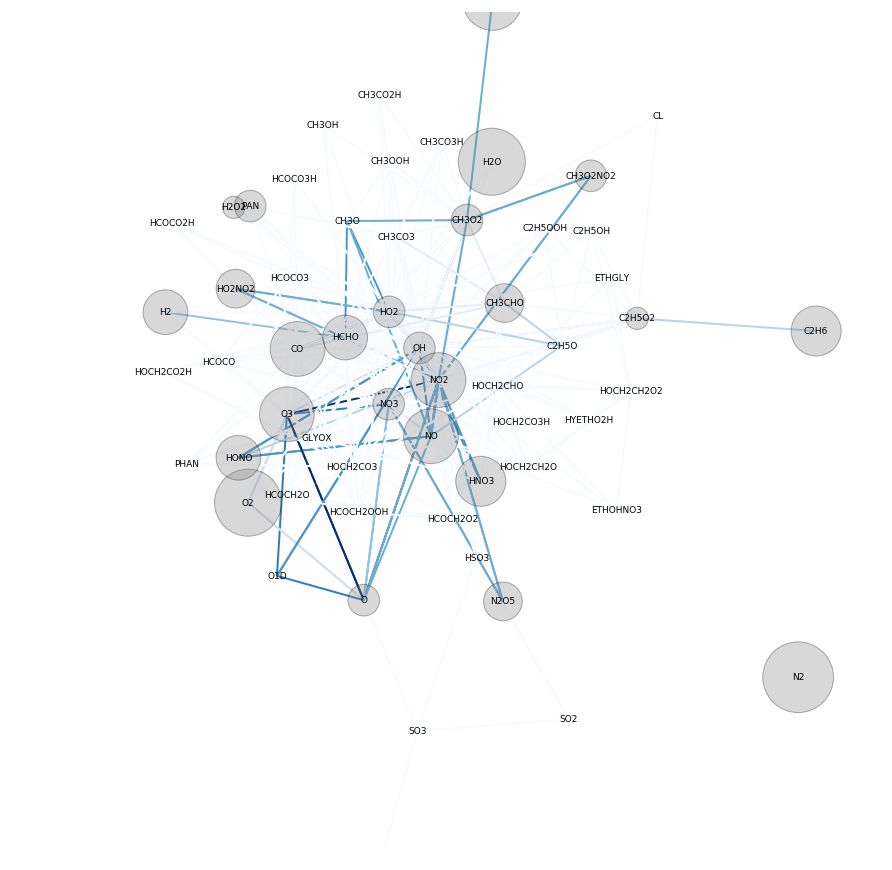

In [12]:
# Draw main network
fig, ax = plt.subplots(figsize=(15,15), facecolor='white')
nx.draw_networkx_nodes(scheme, pos, ax=ax, node_size=node_sizes, node_color='grey', alpha=0.3)
nx.draw_networkx_labels(scheme, pos, ax=ax, font_size=9)
nx.draw_networkx_edges(scheme, pos, ax=ax, width=2, edge_color=edge_colors, edge_cmap=plt.cm.Blues, arrows=False)
# nx.draw_networkx_edge_labels(scheme, pos, edge_labels=link_labels, font_size=7) # haven't corrected them yet
_ = ax.axis('off')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
# plt.title('', fontsize=20) # CheT: highlight MN chemistry

In [ ]:
# TODO: study!
# d1 = collections.OrderedDict([(k, node_size_plot_ctg[k]) for k in nodes])
# d2 = collections.OrderedDict(sorted(node_size_plot_ctg.items(), key=lambda t: nodes.index(t[0])))

In [ ]:
# Select species to highlight
selected_spcs = []
# selected_spcs = ['CH3NO3', 'C2H5NO3', 'IC3H7NO3', 'NC3H7NO3', 'NC4H9NO3', 'SC4H9NO3', 'IC4H9NO3', 'TC4H9NO3', 
#              'PEANO3', 'PEBNO3', 'PECNO3', 'IPEANO3', 'IPEBNO3', 'IPECNO3']
# Filter first-order precursors and products of selected species
selected_spcs_and_depends = []
for n, m in scheme.edges():
    if n in selected_spcs or m in selected_spcs:
        selected_spcs_and_depends.append(n)
        selected_spcs_and_depends.append(m)
selected_spcs_and_depends = set(selected_spcs_and_depends)
# Filter edge labels for production and destruction of selected species
selected_spcs_labels = {k: v for k, v in link_labels.items() if any([i in selected_spcs for i in k])}
# Create subgraph with selected species highlighted
SG=scheme.subgraph(selected_spcs_and_depends)

In [ ]:
# Orig
# Draw main network
fig, ax = plt.subplots(figsize=(20,20), facecolor='white')
nx.draw_networkx_nodes(scheme, pos, ax=ax, node_size=30, node_color='grey', alpha=0.3)
nx.draw_networkx_labels(scheme, pos, ax=ax, font_size=9)
nx.draw_networkx_edges(scheme, pos, ax=ax, width=0.5, edge_color='grey')
nx.draw_networkx_edge_labels(scheme, pos, edge_labels=link_labels, font_size=7)
# Draw subnetwork on top of the main network
nx.draw_networkx_nodes(SG, pos, ax=ax, node_size=30, node_color='r', alpha=0.3) # r
nx.draw_networkx_labels(SG, pos, ax=ax, font_size=9, font_color='r') # k
# nx.draw_networkx_edges(SG, pos, ax=ax, width=1.0, edge_color='r') # r
# nx.draw_networkx_edge_labels(SG, pos, edge_labels=selected_spcs_labels, font_size=7)
_ = ax.axis('off')
ax.set_xlim(-300, 350)
ax.set_ylim(-300, 350)
plt.title('CheT+MN: highlight new species and reactions from MN chemistry', fontsize=20) # CheT: highlight MN chemistry

In [ ]:
# Save network
if MCM_RHC1C5:
    fig.savefig('/local/mwe14avu/UEA/PhD/results/plot_network/MCM_RHC1C5_allRONO2marked.svg', format='svg', dpi=100, bbox_inches='tight')
if CheT:
    fig.savefig('/local/mwe14avu/UEA/PhD/results/plot_network/CheT_smth.svg', format='svg', dpi=100, bbox_inches='tight')

In [ ]:
# TODO: find a way to highlight list of nodes and endges without constructing subnetwork